In [2]:
import pandas as pd
from scipy import spatial
import libpysal as ps
import numpy as np
from pointpats import PointPattern
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext
%matplotlib inline
import matplotlib.pyplot as plt
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern, as_window
from pointpats import PoissonPointProcess as csr
from pointpats.geometry import *
from pointpats.ripley import _prepare # very important to prepare data :)
from pointpats.geometry import (
    area as _area,
    bbox as _bbox,
    contains as _contains,
    k_neighbors as _k_neighbors,
    build_best_tree as _build_best_tree,
    prepare_hull as _prepare_hull,
)

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.ht

In [3]:
def kinhom(coords_array):
    coordinates, support, distances, metric, hull, edge_correction = _prepare(
            coords_array, support=None,
        distances=None,
        metric="euclidean",
        hull=None,
        edge_correction=None,
        )

    hull = _prepare_hull(coords_array, hull = None)

    n = coordinates.shape[0]
    upper_tri_distances = spatial.distance.pdist(coordinates, metric='euclidean') # OK  DISTANCES 
    n_pairs_less_than_d = (upper_tri_distances < support.reshape(-1, 1)).sum(axis=1) # N PAIRS LESS THAN DISTANCES 
    lambda_1 = n / _area(hull) #INTENSITY 
    k_estimate = ((n_pairs_less_than_d * 2) / n) / lambda_1 # OK  ((N PAIRS LESS THAN DISTANCE * 2) / N POINTS )/ INTENSITY    #BRING UP THE POINT FROM BADDELEY THAT ITS SHOULD BE N-1\HULL AREAS (PP 204)
    uno_fratto_a = 1/ _area(hull)
    lambda_2 = (n * (n - 1)) / (_area(hull))**2
    k_inhom_estimate = ((n_pairs_less_than_d *2) / (lambda_2)) * uno_fratto_a
    return support, k_inhom_estimate

In [4]:
data = pd.read_pickle('/Users/gocchini/Desktop/paper_3/data/tang_non_sus.pkl')

In [5]:
x = data['lat'].to_list()
y = data['long'].to_list()
coords_array = np.array(list(zip(x, y)))

In [6]:
kinhom_est = kinhom(coords_array)

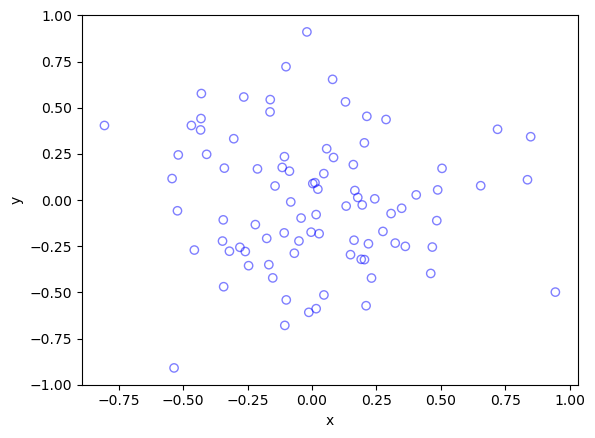

In [7]:
# Simulate an inhomogeneous Poisson point process on a rectangle

import numpy as np;  
import matplotlib.pyplot as plt 
from scipy.optimize import minimize  
from scipy import integrate  


# Simulate window and get area
x_min=-1
x_max=1
y_min=-1
y_max=1
x_delta = x_max-x_min
y_delta = y_max-y_min # rectangle dimensions
area = x_delta*y_delta
 

n_sim = 10 ** 3  # number of simulations

s = 0.5  # scale parameter


# Point process parameters
def fun_lambda(x, y):
    return 100 * np.exp(-(x ** 2 + y ** 2) / s ** 2)  # intensity function -> driving intensity Λ


############################################ FIND MAX LAMBDA ############################################
# For an intensity function lambda, given by function fun_lambda,
# finds the maximum of lambda in a rectangular region given by above parameters
def fun_Neg(x):
    return -fun_lambda(x[0], x[1])  # negative of lambda


xy0 = [(x_min + x_max) / 2, (y_min + y_max) / 2]  # initial value(ie centre)
# Find largest lambda value
resultsOpt = minimize(fun_Neg, xy0, bounds=((x_min, x_max), (y_min, y_max)))
lambda_neg_min = resultsOpt.fun  # retrieve minimum value found by minimize
lambda_max = -lambda_neg_min


############################################

# define thinning probability function
def fun_p(x, y):
    return fun_lambda(x, y) / lambda_max

# for collecting statistics -- set numbSim=1 for one simulation
n_kept = np.zeros(n_sim)  # vector to record number of points
for ii in range(n_sim):
    # Simulate a Poisson point process
    n_points = np.random.poisson(area * lambda_max)  # Poisson number of points
    xx = np.random.uniform(0, x_delta, ((n_points, 1))) + x_min  # x coordinates of Poisson points
    yy = np.random.uniform(0, y_delta, ((n_points, 1))) + y_min  # y coordinates of Poisson points

    # calculate spatially-dependent thinning probabilities
    p = fun_p(xx, yy)

    # Generate Bernoulli variables for thinning
    boolean_kept = np.random.uniform(0, 1, ((n_points, 1))) < p;  # points to be retained

    # x/y locations of retained points
    xx_kept = xx[boolean_kept]
    yy_kept = yy[boolean_kept]
    n_kept[ii] = xx_kept.size 

# Plotting
plt.scatter(xx_kept, yy_kept, edgecolor='b', facecolor='none', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')

# run empirical test on number of points generated
if n_sim >= 10:
    # total mean measure (average number of points)
    LambdaNumerical = integrate.dblquad(fun_lambda, x_min, x_max, lambda x: y_min, lambda y: y_max)[0]
    # Test: as numbSim increases, numbPointsMean converges to LambdaNumerical
    numbPointsMean = np.mean(n_kept)
    # Test: as numbSim increases, numbPointsVar converges to LambdaNumerical
    numbPointsVar = np.var(n_kept)

In [8]:
inhom_ppp = np.array(list(zip(xx_kept, yy_kept)))

In [9]:
kinhom_est_ppp = kinhom(inhom_ppp)

In [10]:
def normalizer(values):
    normalized_counts = []
    for x in values:
        normalized_counts.append(x/sum(values))
    return normalized_counts

In [11]:
norm_kinhom_est = normalizer(kinhom_est[1])
norm_kinhom_est_ppp = normalizer(kinhom_est_ppp[1])

In [12]:
norm_kinhom_est_r = normalizer(kinhom_est[0])
norm_kinhom_est_ppp_r = normalizer(kinhom_est_ppp[0])

Text(0, 0.5, 'Kinhom(r)')

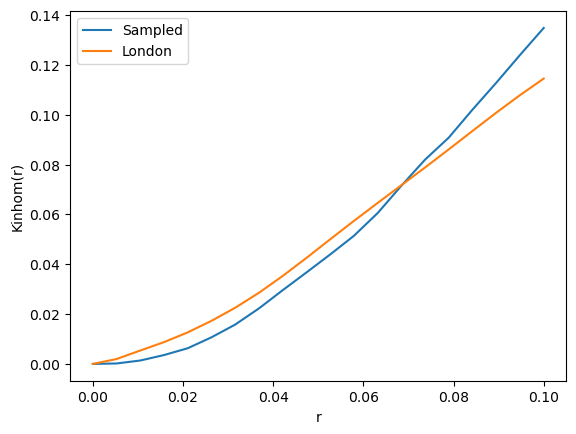

In [13]:
plt.plot( norm_kinhom_est_ppp_r, norm_kinhom_est_ppp,label = 'Sampled')
plt.plot( norm_kinhom_est_r, norm_kinhom_est, label = 'London')
plt.legend()
plt.xlabel('r')
plt.ylabel('Kinhom(r)')